In [1]:
import os
from importlib.resources import files

import copy
import numpy as np
import torch
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry, LinearField
from learn_embedding.utils import *
from learn_embedding.loss import *

## Load Dataset

In [2]:
dataset = "Khamesh"
data_path = files('learn_embedding').joinpath(os.path.join('data/lasahandwriting', '{}.mat'.format(dataset)))
data = LasaHandwriting(data_path)
train_x, train_y, test_x, test_y = data.load().process().dataset(target="acceleration", split=0.2, visualize=False)
# train_x, train_y, test_x, test_y = data.load().dataset(target="acceleration", split=0.2, visualize=False)
dim = train_y.shape[1]

## Torch Configuration

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device).requires_grad_(True)
test_y = torch.from_numpy(test_y).float().to(device)

## Create Model

In [4]:
model_first = FirstGeometry(Embedding(FeedForward(dim, [64]*2, 1)), 
                      torch.tensor([0.0,0.0]).to(device), 
                      SPD(dim)).to(device)
TorchHelper.load(model_first, '../outputs/' + dataset + '_1')

In [5]:
# torch.manual_seed(1337)

# approximator = KernelExpansion(train_x[:, :dim])

# approximator = KernelMachine(dim, 1000, 1, length=0.4)

num_neurons = [64]
num_layers = 2
approximator = FeedForward(dim, num_neurons*num_layers, 1)

# embedding = copy.deepcopy(model_first.embedding)
# TorchHelper.set_grad(embedding, False)
embedding = Embedding(approximator)

# stiffness = copy.deepcopy(model_first.stiffness)
# dissipation = copy.deepcopy(model_first.stiffness)
# dissipation.eigval = 2*dissipation.eigval
stiffness = SPD(dim)
dissipation = SPD(dim)

attractor = torch.tensor([0.0,0.0]).to(device)

field = LinearField(attractor, Spherical(1.0, True))
field_weight = 1.0

model = SecondGeometry(embedding, attractor, stiffness, dissipation).to(device)
# TorchHelper.load(model, '../outputs/' + dataset + '_2')
model.velocity_embedding = False
TorchHelper.set_grad(model_first, False)

## Train

In [6]:
trainer = Trainer(model, train_x, train_y)

trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-8)
# trainer.optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, weight_decay=1e-1)

trainer.loss = torch.nn.MSELoss()
# trainer.loss = torch.nn.SmoothL1Loss()
# trainer.loss = WeighedMagnitudeDirectionLoss(magnitude_weight=0.0, direction_weight=1.0)

trainer.options(normalize=False, shuffle=True, print_loss=True,epochs=1000)

trainer.train()
TorchHelper.save(model, '../outputs/' + dataset + '_2')

EPOCH:  0 ITER:  0 LR:  0.01 LOSS:  2902.836669921875
EPOCH:  1 ITER:  0 LR:  0.01 LOSS:  2841.469970703125
EPOCH:  2 ITER:  0 LR:  0.01 LOSS:  2780.409423828125
EPOCH:  3 ITER:  0 LR:  0.01 LOSS:  2729.55126953125
EPOCH:  4 ITER:  0 LR:  0.01 LOSS:  2686.83642578125
EPOCH:  5 ITER:  0 LR:  0.01 LOSS:  2636.57763671875
EPOCH:  6 ITER:  0 LR:  0.01 LOSS:  2581.39990234375
EPOCH:  7 ITER:  0 LR:  0.01 LOSS:  2521.1962890625
EPOCH:  8 ITER:  0 LR:  0.01 LOSS:  2446.30029296875
EPOCH:  9 ITER:  0 LR:  0.01 LOSS:  2362.56396484375
EPOCH:  10 ITER:  0 LR:  0.01 LOSS:  2280.55322265625
EPOCH:  11 ITER:  0 LR:  0.01 LOSS:  2191.82373046875
EPOCH:  12 ITER:  0 LR:  0.01 LOSS:  2107.40283203125
EPOCH:  13 ITER:  0 LR:  0.01 LOSS:  2023.14501953125
EPOCH:  14 ITER:  0 LR:  0.01 LOSS:  1951.4193115234375
EPOCH:  15 ITER:  0 LR:  0.01 LOSS:  1888.4615478515625
EPOCH:  16 ITER:  0 LR:  0.01 LOSS:  1832.9691162109375
EPOCH:  17 ITER:  0 LR:  0.01 LOSS:  1793.1409912109375
EPOCH:  18 ITER:  0 LR:  0.0

EPOCH:  155 ITER:  0 LR:  0.01 LOSS:  592.0098266601562
EPOCH:  156 ITER:  0 LR:  0.01 LOSS:  574.668701171875
EPOCH:  157 ITER:  0 LR:  0.01 LOSS:  550.1893920898438
EPOCH:  158 ITER:  0 LR:  0.01 LOSS:  576.83154296875
EPOCH:  159 ITER:  0 LR:  0.01 LOSS:  565.5153198242188
EPOCH:  160 ITER:  0 LR:  0.01 LOSS:  543.513671875
EPOCH:  161 ITER:  0 LR:  0.01 LOSS:  547.2072143554688
EPOCH:  162 ITER:  0 LR:  0.01 LOSS:  551.587646484375
EPOCH:  163 ITER:  0 LR:  0.01 LOSS:  535.99951171875
EPOCH:  164 ITER:  0 LR:  0.01 LOSS:  528.3197021484375
EPOCH:  165 ITER:  0 LR:  0.01 LOSS:  538.8604736328125
EPOCH:  166 ITER:  0 LR:  0.01 LOSS:  535.5150756835938
EPOCH:  167 ITER:  0 LR:  0.01 LOSS:  519.5488891601562
EPOCH:  168 ITER:  0 LR:  0.01 LOSS:  515.3363037109375
EPOCH:  169 ITER:  0 LR:  0.01 LOSS:  518.7391967773438
EPOCH:  170 ITER:  0 LR:  0.01 LOSS:  526.5926513671875
EPOCH:  171 ITER:  0 LR:  0.01 LOSS:  530.0255737304688
EPOCH:  172 ITER:  0 LR:  0.01 LOSS:  525.1142578125
EPOCH

EPOCH:  311 ITER:  0 LR:  0.01 LOSS:  373.7237243652344
EPOCH:  312 ITER:  0 LR:  0.01 LOSS:  386.1044006347656
EPOCH:  313 ITER:  0 LR:  0.01 LOSS:  416.8138427734375
EPOCH:  314 ITER:  0 LR:  0.01 LOSS:  391.7744445800781
EPOCH:  315 ITER:  0 LR:  0.01 LOSS:  370.41827392578125
EPOCH:  316 ITER:  0 LR:  0.01 LOSS:  368.8044128417969
EPOCH:  317 ITER:  0 LR:  0.01 LOSS:  381.83770751953125
EPOCH:  318 ITER:  0 LR:  0.01 LOSS:  397.11785888671875
EPOCH:  319 ITER:  0 LR:  0.01 LOSS:  375.5022277832031
EPOCH:  320 ITER:  0 LR:  0.01 LOSS:  360.6206359863281
EPOCH:  321 ITER:  0 LR:  0.01 LOSS:  362.3349304199219
EPOCH:  322 ITER:  0 LR:  0.01 LOSS:  374.1865234375
EPOCH:  323 ITER:  0 LR:  0.01 LOSS:  397.98974609375
EPOCH:  324 ITER:  0 LR:  0.01 LOSS:  374.0189514160156
EPOCH:  325 ITER:  0 LR:  0.01 LOSS:  397.18865966796875
EPOCH:  326 ITER:  0 LR:  0.01 LOSS:  382.0279541015625
EPOCH:  327 ITER:  0 LR:  0.01 LOSS:  393.2667541503906
EPOCH:  328 ITER:  0 LR:  0.01 LOSS:  392.2344360

EPOCH:  466 ITER:  0 LR:  0.01 LOSS:  270.3169860839844
EPOCH:  467 ITER:  0 LR:  0.01 LOSS:  329.79718017578125
EPOCH:  468 ITER:  0 LR:  0.01 LOSS:  450.1898193359375
EPOCH:  469 ITER:  0 LR:  0.01 LOSS:  362.8841552734375
EPOCH:  470 ITER:  0 LR:  0.01 LOSS:  287.68524169921875
EPOCH:  471 ITER:  0 LR:  0.01 LOSS:  280.85760498046875
EPOCH:  472 ITER:  0 LR:  0.01 LOSS:  335.8333435058594
EPOCH:  473 ITER:  0 LR:  0.01 LOSS:  353.41497802734375
EPOCH:  474 ITER:  0 LR:  0.01 LOSS:  280.3033752441406
EPOCH:  475 ITER:  0 LR:  0.01 LOSS:  284.3085632324219
EPOCH:  476 ITER:  0 LR:  0.01 LOSS:  333.5909729003906
EPOCH:  477 ITER:  0 LR:  0.01 LOSS:  314.92498779296875
EPOCH:  478 ITER:  0 LR:  0.01 LOSS:  278.60699462890625
EPOCH:  479 ITER:  0 LR:  0.01 LOSS:  260.09442138671875
EPOCH:  480 ITER:  0 LR:  0.01 LOSS:  282.22320556640625
EPOCH:  481 ITER:  0 LR:  0.01 LOSS:  297.6017761230469
EPOCH:  482 ITER:  0 LR:  0.01 LOSS:  275.128662109375
EPOCH:  483 ITER:  0 LR:  0.01 LOSS:  257

EPOCH:  617 ITER:  0 LR:  0.01 LOSS:  220.34361267089844
EPOCH:  618 ITER:  0 LR:  0.01 LOSS:  229.24732971191406
EPOCH:  619 ITER:  0 LR:  0.01 LOSS:  236.1881103515625
EPOCH:  620 ITER:  0 LR:  0.01 LOSS:  217.5377197265625
EPOCH:  621 ITER:  0 LR:  0.01 LOSS:  217.18426513671875
EPOCH:  622 ITER:  0 LR:  0.01 LOSS:  224.36619567871094
EPOCH:  623 ITER:  0 LR:  0.01 LOSS:  219.47274780273438
EPOCH:  624 ITER:  0 LR:  0.01 LOSS:  211.49740600585938
EPOCH:  625 ITER:  0 LR:  0.01 LOSS:  212.56427001953125
EPOCH:  626 ITER:  0 LR:  0.01 LOSS:  215.56271362304688
EPOCH:  627 ITER:  0 LR:  0.01 LOSS:  216.3212127685547
EPOCH:  628 ITER:  0 LR:  0.01 LOSS:  213.55223083496094
EPOCH:  629 ITER:  0 LR:  0.01 LOSS:  207.04115295410156
EPOCH:  630 ITER:  0 LR:  0.01 LOSS:  202.77487182617188
EPOCH:  631 ITER:  0 LR:  0.01 LOSS:  206.13937377929688
EPOCH:  632 ITER:  0 LR:  0.01 LOSS:  208.8388214111328
EPOCH:  633 ITER:  0 LR:  0.01 LOSS:  214.44871520996094
EPOCH:  634 ITER:  0 LR:  0.01 LOSS

EPOCH:  772 ITER:  0 LR:  0.01 LOSS:  198.64012145996094
EPOCH:  773 ITER:  0 LR:  0.01 LOSS:  271.2648620605469
EPOCH:  774 ITER:  0 LR:  0.01 LOSS:  244.64089965820312
EPOCH:  775 ITER:  0 LR:  0.01 LOSS:  192.7755889892578
EPOCH:  776 ITER:  0 LR:  0.01 LOSS:  215.0723419189453
EPOCH:  777 ITER:  0 LR:  0.01 LOSS:  237.11070251464844
EPOCH:  778 ITER:  0 LR:  0.01 LOSS:  221.75331115722656
EPOCH:  779 ITER:  0 LR:  0.01 LOSS:  186.58766174316406
EPOCH:  780 ITER:  0 LR:  0.01 LOSS:  198.65396118164062
EPOCH:  781 ITER:  0 LR:  0.01 LOSS:  229.4008026123047
EPOCH:  782 ITER:  0 LR:  0.01 LOSS:  223.47230529785156
EPOCH:  783 ITER:  0 LR:  0.01 LOSS:  200.48350524902344
EPOCH:  784 ITER:  0 LR:  0.01 LOSS:  183.39431762695312
EPOCH:  785 ITER:  0 LR:  0.01 LOSS:  188.8984375
EPOCH:  786 ITER:  0 LR:  0.01 LOSS:  206.9474334716797
EPOCH:  787 ITER:  0 LR:  0.01 LOSS:  210.811767578125
EPOCH:  788 ITER:  0 LR:  0.01 LOSS:  205.20375061035156
EPOCH:  789 ITER:  0 LR:  0.01 LOSS:  188.771

EPOCH:  928 ITER:  0 LR:  0.01 LOSS:  217.65603637695312
EPOCH:  929 ITER:  0 LR:  0.01 LOSS:  228.8057861328125
EPOCH:  930 ITER:  0 LR:  0.01 LOSS:  245.37828063964844
EPOCH:  931 ITER:  0 LR:  0.01 LOSS:  218.984375
EPOCH:  932 ITER:  0 LR:  0.01 LOSS:  190.15806579589844
EPOCH:  933 ITER:  0 LR:  0.01 LOSS:  168.68833923339844
EPOCH:  934 ITER:  0 LR:  0.01 LOSS:  170.6693115234375
EPOCH:  935 ITER:  0 LR:  0.01 LOSS:  189.12359619140625
EPOCH:  936 ITER:  0 LR:  0.01 LOSS:  200.6763458251953
EPOCH:  937 ITER:  0 LR:  0.01 LOSS:  204.09226989746094
EPOCH:  938 ITER:  0 LR:  0.01 LOSS:  188.34872436523438
EPOCH:  939 ITER:  0 LR:  0.01 LOSS:  174.7313995361328
EPOCH:  940 ITER:  0 LR:  0.01 LOSS:  165.73085021972656
EPOCH:  941 ITER:  0 LR:  0.01 LOSS:  166.20411682128906
EPOCH:  942 ITER:  0 LR:  0.01 LOSS:  173.91004943847656
EPOCH:  943 ITER:  0 LR:  0.01 LOSS:  184.606689453125
EPOCH:  944 ITER:  0 LR:  0.01 LOSS:  199.796630859375
EPOCH:  945 ITER:  0 LR:  0.01 LOSS:  208.29501

## Test

In [7]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_v = torch.zeros_like(grid_x).to(device).requires_grad_(True)

grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)
grid_vr = torch.zeros_like(grid_xr).to(device).requires_grad_(True)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### Potential

In [8]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

Text(0.5, 1.0, 'Potential Function $\\phi$')

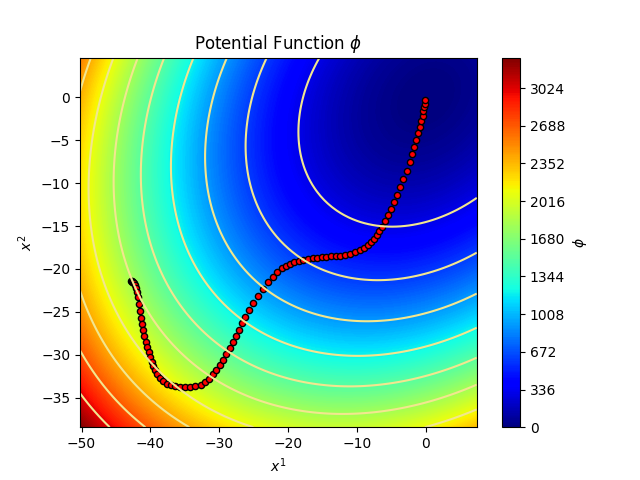

In [9]:
norm = matplotlib.colors.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::10, 0], train_x.cpu().detach()[::10, 1], s=20, edgecolors='k', c='red')
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
fig.colorbar(im, ax=ax, label=r"$\phi$")
# ax.axis("equal")
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])
ax.set_title('Potential Function $\phi$')

### Vector Field & Streamlines

In [10]:
obstacle_radius = 0.1 # 0.05 , 0.1
obstacle = torch.tensor([[-0.4,-0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
# phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device)
phi = KernelDeformation(obstacle.to(device), weights = 10.0*torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
# embedding.local_deformation = phi


field = model(torch.cat((grid_x,grid_v),dim=1))
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), la=0.5, lb=0.5, samples=3).to(device).requires_grad_(True)
v0 = torch.zeros_like(x0).to(device).requires_grad_(True)
streamlines = Integrator.second_order(dynamics=model,x0=torch.cat((x0,v0),dim=1),T=10.0, dt=0.01).cpu().detach().numpy()

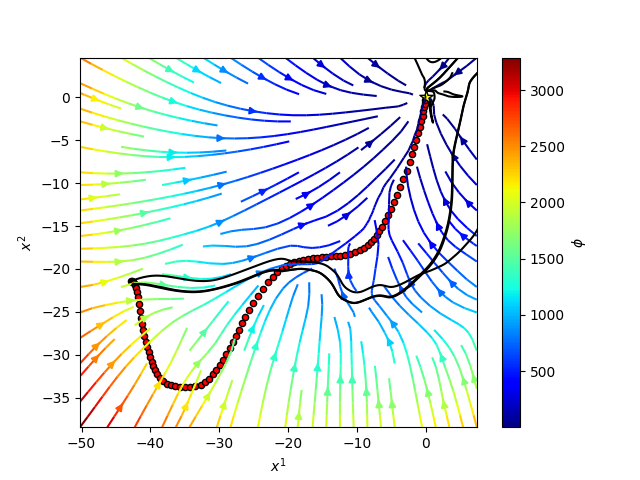

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet")
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k')
ax.scatter(train_x.cpu().detach()[::10, 0], train_x.cpu().detach()[::10, 1], s=20, edgecolors='k', c='red')
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=100, edgecolors='k', c='yellow', marker="*")
# ax.axis('square')
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
fig.colorbar(mappable,  ax=ax, label=r"$\phi$")

### Embedding

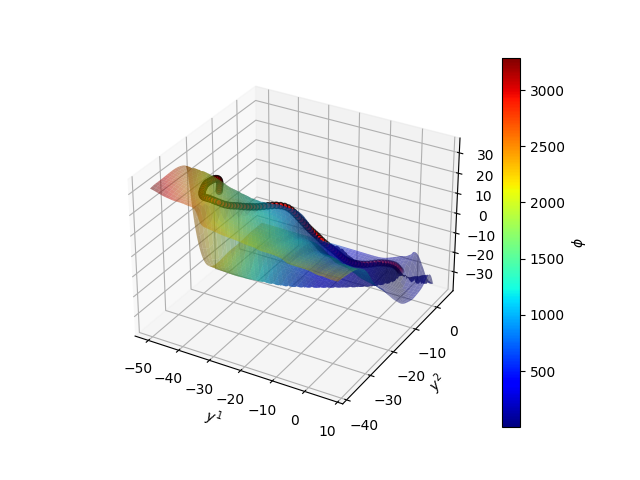

In [12]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()
train_embedding = embedding(train_x[:,:dim]).cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
im = ax.plot_surface(x_embedding, y_embedding, z_embedding,facecolors=colors, antialiased=True, linewidth=0, alpha=0.5)
ax.scatter(train_embedding[::10, 0], train_embedding[::10, 1], train_embedding[::10, 2], s=20, edgecolors='k', c='red')
ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')
fig.colorbar(mappable, ax=ax, label=r"$\phi$")

### Metric

Text(0.5, 1.0, 'Metric Determinant')

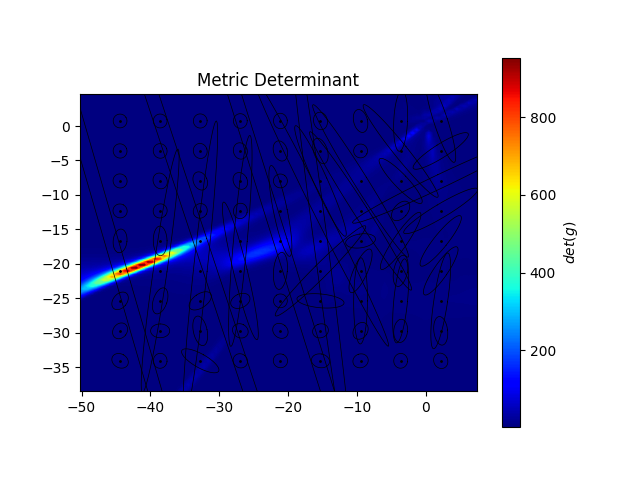

In [13]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)

ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

norm = matplotlib.colors.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(x, y, det_metric, 500, cmap="jet")
ax.scatter(x[10::10,10::10,], y[10::10,10::10], color="k", s=1)

for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i,:], ellipses_y[i,:], color="k", linewidth=0.5)

fig.colorbar(mappable,  ax=ax, label=r"$det(g)$")
ax.axis('square')
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])
ax.set_title('Metric Determinant')

### Christoffel Symbols

Text(0.5, 1.0, 'Sampled Trajectory with Christoffel Ellipses')

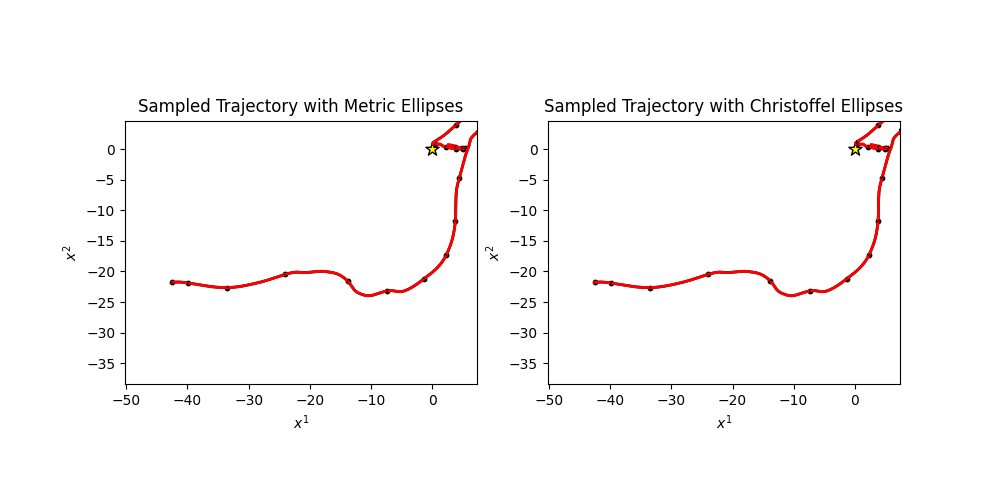

In [14]:
step = 40
eval_scale = 10
x_sampled = torch.from_numpy(streamlines[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(streamlines[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())
metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()/eval_scale

christoffel_sampled = embedding.christoffel(x_sampled, metric_sampled)
christoffel_sampled = torch.einsum('bqij,bi->bqj', christoffel_sampled, v_sampled)
christoffel_evals,christoffel_evecs = torch.linalg.eig(christoffel_sampled)
christoffel_evals = torch.real(christoffel_evals)
christoffel_evecs = torch.real(christoffel_evecs)
christoffel_ellipses = torch.stack((christoffel_evals[:, 0].unsqueeze(-1)*theta.cos(), christoffel_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
christoffel_ellipses = torch.bmm(christoffel_evecs, christoffel_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()/eval_scale

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='k', linewidth='2')
ax.plot(streamlines[:, 0, 0], streamlines[:, 0, 1], color='r', linewidth='2')
ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=10)
for i in range(0, metric_ellipses.shape[0], step):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=0.5)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=100, edgecolors='k', c='yellow', marker="*")
if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
ax.axis('square')
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
ax.set_title('Sampled Trajectory with Metric Ellipses')

ax = fig.add_subplot(122)
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='k', linewidth='2')
ax.plot(streamlines[:, 0, 0], streamlines[:, 0, 1], color='r', linewidth='2')
ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=10)
for i in range(0,christoffel_ellipses.shape[0],step):
    ax.plot(x_sampled[i, 0].detach().cpu() + christoffel_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + christoffel_ellipses[i, :, 1], color="k", linewidth=0.5)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=100, edgecolors='k', c='yellow', marker="*")
if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
ax.axis('square')
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
ax.set_title('Sampled Trajectory with Christoffel Ellipses')